## Import the Library

In [43]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2
import random
from functools import reduce

## Add your crendentials

In [203]:
# Insert your Spotify username and the credentials that you obtained from spotify developer
cid = 'XXXXXXXXXXXXXXXXXXXX'
secret = 'XXXXXXXXXXXXXXXXX'
redirect_uri='http://localhost:8910/callback'
username = 'XXXXXXXXXXXXXXX'

In [204]:
# Once the Authorisation is complete, we just need to `sp` to call the APIs
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

## Fetch the user's favourite songs
Now the API authnetication is complete, let's test it by getting users favourite songs

In [ ]:
results = sp.current_user_top_tracks(limit=50, offset=0,time_range='medium_term')
results

In [8]:
# Convert it to Dataframe
track_name = []
track_id = []
artist = []
album = []
duration = []
popularity = []
for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_favourite = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "duration": duration, 
                             "popularity": popularity})

df_favourite

track_name  \
0                                             Alright   
1                                                Viol   
2                                     Blinding Lights   
3                                      Come On Eileen   
4      Thunderclouds (feat. Sia, Diplo, and Labrinth)   
5                                Empire State Of Mind   
6             Genius (feat. Sia, Diplo, and Labrinth)   
7                                           Paparazzi   
8   The Four Seasons, Violin Concerto No. 4 in F M...   
9                                         Close To Me   
10                                  Never Miss A Beat   
11                                         Holy Grail   
12                                   Derdimi Dökersem   
13                                everything i wanted   
14                                       Sunset Lover   
15                                 Morning Has Broken   
16                                             Easier   
17                      Forever Young - 2019 Remaster   
18                                          On My Way   
19                                     Just a Thought   
20                        Cry Me a River - In Session   
21            La Gioconda / Act 3: Dance Of The Hours   
22                                    Around the Fire   
23                               Locked out of Heaven   
24                        Girls Just Want to Have Fun   
25                                               Ruby   
26                                             Maniac   
27                                       Outer Sunset   
28                                            HUMBLE.   
29                        Dusk Till Dawn - Radio Edit   
30                                          Moodswing   
31  Winter - Lux Aeterna (From "Requiem for a Dream")   
32                                        Take Me Out   
33              The Other Side (Alessia Cara Version)   
34                                  Yahi Meri Zindagi   
35                                         Gucci Gang   
36                                         Take on Me   
37                                           Memories   
38                                  Blau (feat. Sido)   
39                                         Trampoline   
40  There Is a Light That Never Goes Out - 2011 Re...   
41                              Every Breath You Take   
42                    No Promises (feat. Demi Lovato)   
43  Hasse: Sanctus Petrus et Sancta Maria Magdalen...   
44                             Somewhere Only We Know   
45                                      Feel It Still   
46                                 How to Save a Life   
47                             All The Way Up (Remix)   
48                                         Who Cares?   
49         This Girl (Kungs Vs. Cookin' On 3 Burners)   

                                                album                track_id  \
0                                 To Pimp A Butterfly  3iVcZ5G6tvkXZkZKlMpIUs   
1                                     Conspiracy Pt.2  07aqlD34P6qYrWjRNBt1eW   
2                                     Blinding Lights  0sf12qNH5qcw8qpgymFOqD   
3                            Come On Eileen / Dubious  6nWcEzyxDozQcmxMoNJtYx   
4                LABRINTH, SIA & DIPLO PRESENT... LSD  4lJNen4SMTIJMahALc3DcB   
5                                     The Blueprint 3  2igwFfvr1OAGX9SKDCPBwO   
6                LABRINTH, SIA & DIPLO PRESENT... LSD  4xigPf2sigSPmuFH3qCelB   
7                                            The Fame  02XnQdf7sipaKBBHixz3Zp   
8                   Sinkovsky Plays and Sings Vivaldi  7njAZhca4o80qQdCgyEWya   
9                   The Head On The Door (Remastered)  4xiyq1iRdsxuU1BPUJ490Z   
10                               Off With Their Heads  0bXhjlgUddDlJzHOeVM4Tq   
11                          Magna Carta... Holy Grail  1q9bLSeIlGf2xBvbOkp2Wr   
12                                               Gece  23fiZqYPfs6gDqABl0wyKe   
1

In [9]:
def fetch_audio_features(sp, df):
    playlist = df[['track_id','track_name']] 
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness'],
                              features['mode']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness','duration_ms', 'key',
                                                             'valence', 'speechiness', 'mode'])
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [10]:
df_fav = fetch_audio_features (sp, df_favourite)
df_fav

track_id  \
track_name                                                                   
Alright                                             3iVcZ5G6tvkXZkZKlMpIUs   
Viol                                                07aqlD34P6qYrWjRNBt1eW   
Blinding Lights                                     0sf12qNH5qcw8qpgymFOqD   
Come On Eileen                                      6nWcEzyxDozQcmxMoNJtYx   
Thunderclouds (feat. Sia, Diplo, and Labrinth)      4lJNen4SMTIJMahALc3DcB   
Empire State Of Mind                                2igwFfvr1OAGX9SKDCPBwO   
Genius (feat. Sia, Diplo, and Labrinth)             4xigPf2sigSPmuFH3qCelB   
Paparazzi                                           02XnQdf7sipaKBBHixz3Zp   
The Four Seasons, Violin Concerto No. 4 in F Mi...  7njAZhca4o80qQdCgyEWya   
Close To Me                                         4xiyq1iRdsxuU1BPUJ490Z   
Never Miss A Beat                                   0bXhjlgUddDlJzHOeVM4Tq   
Holy Grail                                          1q9bLSeIlGf2xBvbOkp2Wr   
Derdimi Dökersem                                    23fiZqYPfs6gDqABl0wyKe   
everything i wanted                                 3ZCTVFBt2Brf31RLEnCkWJ   
Sunset Lover                                        0hNduWmlWmEmuwEFcYvRu1   
Morning Has Broken                                  79cE3iVGdtypqWyEhSol98   
Easier                                              4tNXntkAzQ5A2dfYRYGIIQ   
Forever Young - 2019 Remaster                       6XHNIbru8xGohLzHNgxQvF   
On My Way                                           4n7jnSxVLd8QioibtTDBDq   
Just a Thought                                      0nFqtZjnDxfUqUI7CIkk3d   
Cry Me a River - In Session                         2aGMChlUetjLr6fr3cV97u   
La Gioconda / Act 3: Dance Of The Hours             6mmbWSbU5FElQOocyktyUZ   
Around the Fire                                     2m8GbX2w9wOmsdIIs2cCbu   
Locked out of Heaven                                3w3y8KPTfNeOKPiqUTakBh   
Girls Just Want to Have Fun                         4y1LsJpmMti1PfRQV9AWWe   
Ruby                                                2fAIfPLrPUTW1AmJRR428Q   
Maniac                                              0QKfiqpEU4h9ycPSzIFwYe   
Outer Sunset                                        6MUuMaiREbhGc2HvvBYFik   
HUMBLE.                                             7KXjTSCq5nL1LoYtL7XAwS   
Dusk Till Dawn - Radio Edit                         1j4kHkkpqZRBwE0A4CN4Yv   
Moodswing                                           0Zo84WVAetJjKHFNS0dkcf   
Winter - Lux Aeterna (From "Requiem for a Dream")   1Mtdh7trF8bsI89HOTwfNa   
Take Me Out                                         20I8RduZC2PWMWTDCZuuAN   
The Other Side (Alessia Cara Version)               5stBjr01wRUJa6BGqkxPD7   
Yahi Meri Zindagi                                   6ffa3GCSz2wGcb0JQp2obq   
Gucci Gang                                          43ZyHQITOjhciSUUNPVRHc   
Take on Me                                          2WfaOiMkCvy7F5fcp2zZ8L   
Memories                                            2b8fOow8UzyDFAE27YhOZM   
Blau (feat. Sido)                                   1DFIyhRxaDAbZxTMN0BSBu   
Trampoline                                          0lsRatBUs9HNIZAmoGABzk   
There Is a Light That Never Goes Out - 2011 Rem...  0WQiDwKJclirSYG9v5tayI   
Every Breath You Take                               1JSTJqkT5qHq8MDJnJbRE1   
No Promises (feat. Demi Lovato)                     1louJpMmzEicAn7lzDalPW   
Hasse: Sanctus Petrus et Sancta Maria Magdalena...  7C2CTTz4rzXsPfFcOdjBcR   
Somewhere Only We Know                              1SKPmfSYaPsETbRHaiA18G   
Feel It Still                                       6QgjcU0zLnzq5OrUoSZ3OK   
How to Save a Life                                  5fVZC9GiM4e8vu99W0Xf6J   
All The Way Up (Remix)                              2AYTGaclgKXACh13nJRVcV   
Who Cares?                                          38SLXtdFC7NUA2mmZnAc5a   
This Girl (Kungs Vs. Cookin' On 3 Burners)          1A8j067qyiNwQnZT0bzUpZ   

         

In [11]:
df_fav.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alright to This Girl (Kungs Vs. Cookin' On 3 Burners)
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          50 non-null     object 
 1   danceability      50 non-null     float64
 2   acousticness      50 non-null     float64
 3   energy            50 non-null     float64
 4   tempo             50 non-null     float64
 5   instrumentalness  50 non-null     float64
 6   loudness          50 non-null     float64
 7   liveness          50 non-null     float64
 8   duration_ms       50 non-null     int64  
 9   key               50 non-null     int64  
 10  valence           50 non-null     float64
 11  speechiness       50 non-null     float64
 12  mode              50 non-null     int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 5.5+ KB


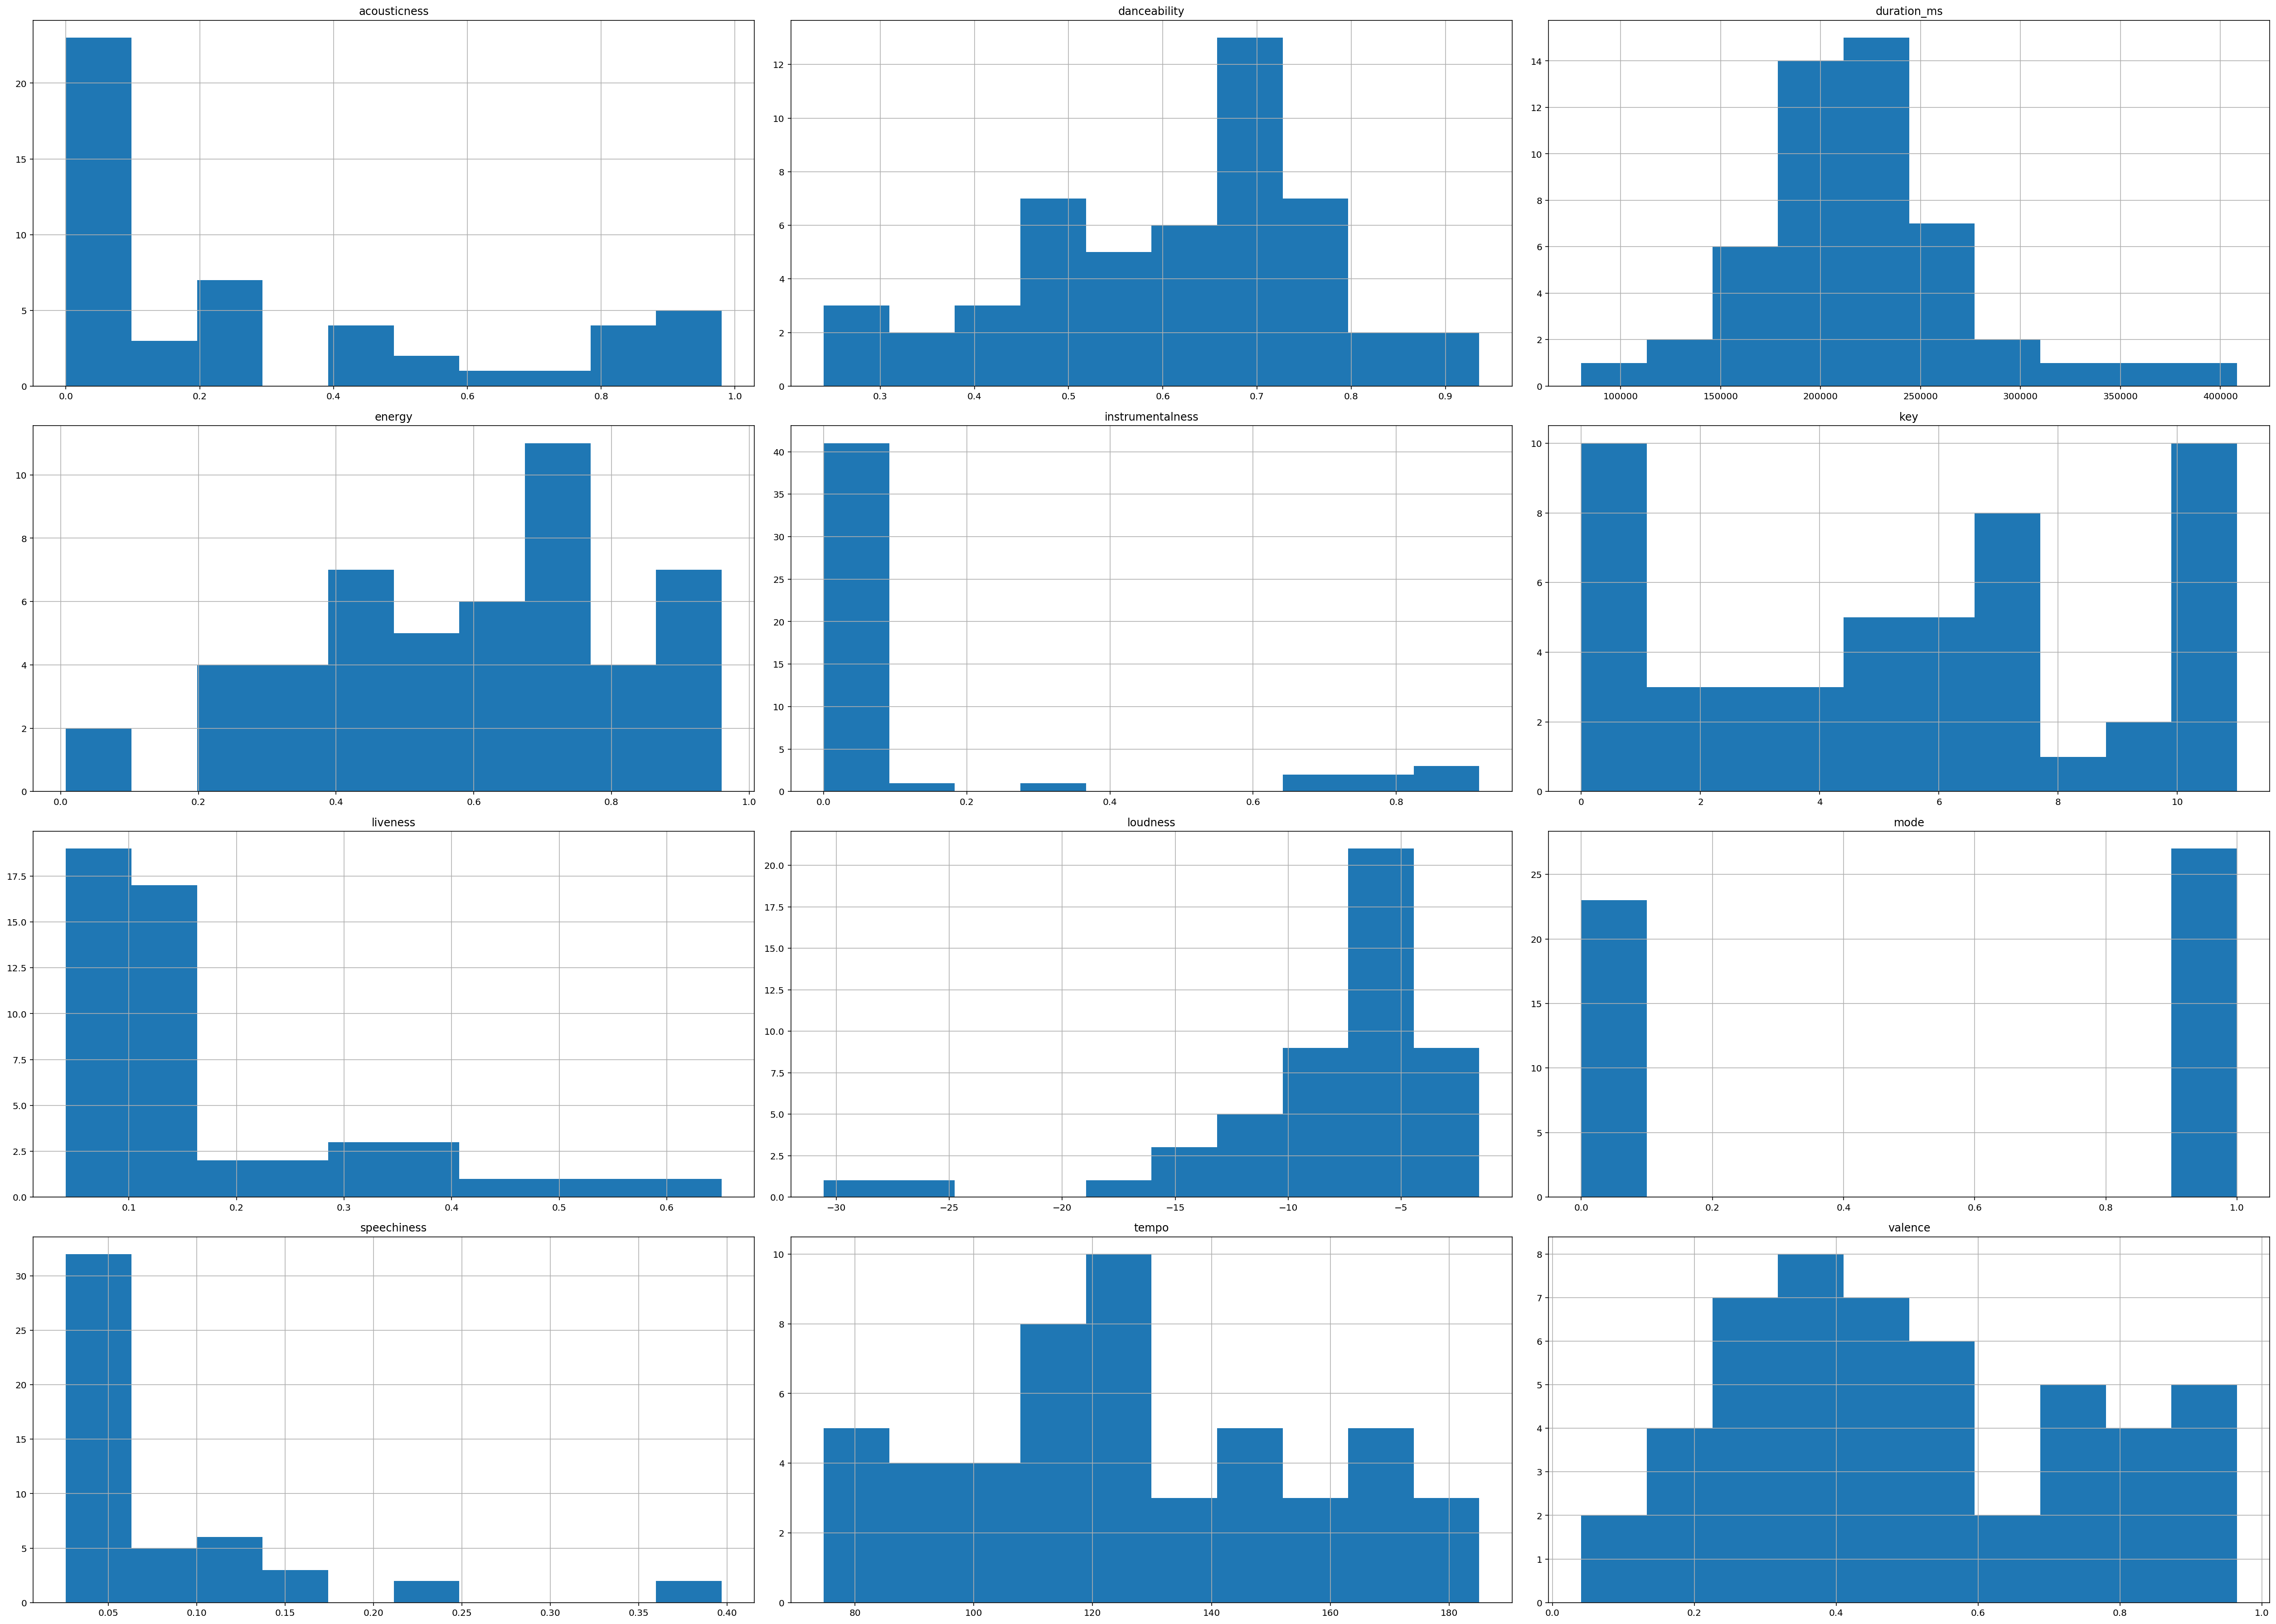

In [12]:
df_fav.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()

I would remove Mode it is binary number

## Fetch the Featured Playlist

In [16]:
response = sp.featured_playlists()
# check the format of the data 
response

{'message': "Editor's picks",
 'playlists': {'href': 'https://api.spotify.com/v1/browse/featured-playlists?timestamp=2020-05-30T06%3A29%3A42&offset=0&limit=20',
  'items': [{'collaborative': False,
    'description': "It's the day after, and the last thing you need is loud noises.",
    'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DWUGsgkESc7qP'},
    'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DWUGsgkESc7qP',
    'id': '37i9dQZF1DWUGsgkESc7qP',
    'images': [{'height': None,
      'url': 'https://i.scdn.co/image/ab67706f00000002693e220755d06b821e5dada9',
      'width': None}],
    'name': 'Hangover Friendly',
    'owner': {'display_name': 'Spotify',
     'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
     'href': 'https://api.spotify.com/v1/users/spotify',
     'id': 'spotify',
     'type': 'user',
     'uri': 'spotify:user:spotify'},
    'primary_color': None,
    'public': None,
    'snapshot_id': 'MTU5MDgyMDE0NiwwMDAwM

In [17]:
# Let's untangle the data
print(response['message'])
playlists = response['playlists']
# For looping through the API request
for i, item in enumerate(playlists['items']):
    print('no: {},Name: {},id: {}, description: {}, total tracks: {}'.
          format(playlists['offset'] + i, item['name'], item['id'],item['description'], item['tracks']['total']))
if playlists['next']:
    response = sp.next(playlists)
else:
    response = None

Editor's picks
no: 0,Name: Hangover Friendly,id: 37i9dQZF1DWUGsgkESc7qP, description: It's the day after, and the last thing you need is loud noises., total tracks: 50
no: 1,Name: Yoga & Meditation,id: 37i9dQZF1DX9uKNf5jGX6m, description: New age music for balancing mind and body., total tracks: 192
no: 2,Name: Guilty Pleasures,id: 37i9dQZF1DX4pUKG1kS0Ac, description: Embrace your secret favorites., total tracks: 151
no: 3,Name: Today's Top Hits,id: 37i9dQZF1DXcBWIGoYBM5M, description: Lady Gaga is on top of the Hottest 50!, total tracks: 50
no: 4,Name: Mellow Morning,id: 37i9dQZF1DWWzVPEmatsUB, description: Have a quiet morning with this mix of something familiar and something new., total tracks: 70
no: 5,Name: I Love My '90s Hip-Hop,id: 37i9dQZF1DX186v583rmzp, description: Real rap music from the golden era., total tracks: 100
no: 6,Name: Bliss,id: 37i9dQZF1DX4bSrsRWE9cd, description: That special feeling of being calm, happy and relaxed at the same time., total tracks: 75
no: 7,Name

Once the data strucutre is sorted, next step is to convert this API call into a data frame

In [18]:
def featured_playlists(sp):
    id = []
    name = []
    num_tracks = []
 # For looping through the API request  
    response = sp.featured_playlists()
    playlists = response['playlists']
    for i, items in enumerate(playlists['items']):
        id.append(items['id'])
        name.append(items['name'])
        num_tracks.append(items['tracks']['total'])

# Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [19]:
df_playlists = featured_playlists(sp)
df_playlists

id                    name  #tracks
0   37i9dQZF1DWUGsgkESc7qP       Hangover Friendly       50
1   37i9dQZF1DX9uKNf5jGX6m       Yoga & Meditation      192
2   37i9dQZF1DX4pUKG1kS0Ac        Guilty Pleasures      151
3   37i9dQZF1DXcBWIGoYBM5M        Today's Top Hits       50
4   37i9dQZF1DWWzVPEmatsUB          Mellow Morning       70
5   37i9dQZF1DX186v583rmzp  I Love My '90s Hip-Hop      100
6   37i9dQZF1DX4bSrsRWE9cd                   Bliss       75
7   37i9dQZF1DWTwnEm1IYyoj           Soft Pop Hits      234
8   37i9dQZF1DX1s9knjP51Oa              Calm Vibes      209
9   37i9dQZF1DX0Aaer4Jzfgm          Easy Classical       65
10  37i9dQZF1DX2Nc3B70tvx0          Ultimate Indie      100
11  37i9dQZF1DXdd3gw5QVjt9        Morning Acoustic       75

## Obtain the tracks from the playlists

In [20]:
def fetch_playlist_tracks(sp, playlistsid): 
    offset = 0
    tracks = []
    # Make the API request
    while True:
            content = sp.playlist_tracks( playlistsid, fields=None, limit=100, offset=offset, market=None)
            tracks += content['items']
        
            if content['next'] is not None:
                offset += 100
            else:
                break
    
    track_id = []
    track_name = []
    
    for track in tracks:
        track_id.append(track['track']['id'])
        track_name.append(track['track']['name'])
    
# Create the final df
    df_playlists_tracks = pd.DataFrame({"track_id":track_id, "track_name": track_name})
    return df_playlists_tracks

In [25]:
# Test the function
fetch_playlist_tracks(sp,'37i9dQZF1DXdd3gw5QVjt9')

track_id               track_name
0   3r4KCd4tNnLHvDwZKGsl82   Our Remains - Acoustic
1   7rbVQAeKbC37aU45N5GOVC                    Twist
2   5zpO1gVyTFv4MeNCEKOEZt                     Body
3   4ZkZeQaJjmKuUPr7SOIjhU  When Creation Was Young
4   3Ed55g8hCz1GmqRTelIPIW            People Change
..                     ...                      ...
70  5tS60Dco9CkCtfRrHY7DGH        Something To Lose
71  566x9tfHqcnSM2LgxdIjR8                      IOU
72  1A3bB2ovgd5LFV874leyZC     Heart and Mind Alike
73  1tLDBychkP96pHT664rJIY       I Knew I Could Fly
74  3PXbcti7P1ZekivSWu48A3                 The Pool

[75 rows x 2 columns]

## Function to fetch the audio features from the songs of given playlist

In [136]:
def fetch_audio_features(sp, playlist_id):
    playlist = fetch_playlist_tracks(sp, playlist_id)
    index = 0
    audio_features = []
    
    # Make the API request
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    # Create an empty list to feed in different charactieritcs of the tracks
    features_list = []
    #Create keys-values of empty lists inside nested dictionary for album
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness']
                             ])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'acousticness', 'energy','tempo', 
                                                             'instrumentalness', 'loudness', 'liveness', 'duration_ms', 'key',
                                                             'valence', 'speechiness'])
    
    # Create the final df, using the 'track_id' as index for future reference
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_audio_features

In [205]:
# Build the dtaframe froms the playlists
for i, playlist in enumerate(df_playlists['id']):
    try:
        string_command = "df_{} = fetch_audio_features(sp, playlist)".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass

Create df_37i9dQZF1DWUGsgkESc7qP = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX9uKNf5jGX6m = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX4pUKG1kS0Ac = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DXcBWIGoYBM5M = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DWWzVPEmatsUB = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX186v583rmzp = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX4bSrsRWE9cd = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DWTwnEm1IYyoj = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX1s9knjP51Oa = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX0Aaer4Jzfgm = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DX2Nc3B70tvx0 = fetch_audio_features(sp, playlist)
Create df_37i9dQZF1DXdd3gw5QVjt9 = fetch_audio_features(sp, playlist)


In [ ]:
def fetch_audio_features_mean(sp, playlist_id):
    Playlist = df_playlist_audio_features(sp, playlist_id)
    return pd.DataFrame(playlist.mean(), columns= [playlist_id])

In [120]:
# Test the function
df = fetch_audio_features_mean(sp, '37i9dQZF1DX0MLFaUdXnjA')
df.head(10)

37i9dQZF1DX0MLFaUdXnjA
danceability                    0.581951
acousticness                    0.474042
energy                          0.462867
tempo                         111.561311
instrumentalness                0.000945
loudness                       -8.220748
liveness                        0.151656
duration_ms                201064.718447
key                             5.796117
valence                         0.381193

In [ ]:
# Merge them together
dataframes = []
# Loop through the filenames to populate dataframes with different dataframes 
for  i in df_playlists['id']:
    dataframes.append(fetch_audio_features_mean(sp, i))

In [122]:
dataframes

[                  37i9dQZF1DWUGsgkESc7qP
 danceability                    0.531040
 acousticness                    0.615013
 energy                          0.373376
 tempo                         117.210820
 instrumentalness                0.031301
 loudness                      -10.223440
 liveness                        0.138172
 duration_ms                211046.280000
 key                             5.220000
 valence                         0.343238
 speechiness                     0.052214,
                   37i9dQZF1DX9uKNf5jGX6m
 danceability                    0.212175
 acousticness                    0.905896
 energy                          0.107958
 tempo                          94.115703
 instrumentalness                0.881552
 loudness                      -23.322240
 liveness                        0.116882
 duration_ms                194629.526042
 key                             4.442708
 valence                         0.067257
 speechiness                     

## Some Machine Learning 
### Find the best suited feature

In [123]:
X = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes)
X

37i9dQZF1DWUGsgkESc7qP  37i9dQZF1DX9uKNf5jGX6m  \
danceability                    0.531040                0.212175   
acousticness                    0.615013                0.905896   
energy                          0.373376                0.107958   
tempo                         117.210820               94.115703   
instrumentalness                0.031301                0.881552   
loudness                      -10.223440              -23.322240   
liveness                        0.138172                0.116882   
duration_ms                211046.280000           194629.526042   
key                             5.220000                4.442708   
valence                         0.343238                0.067257   
speechiness                     0.052214                0.040559   

                  37i9dQZF1DX4pUKG1kS0Ac  37i9dQZF1DXcBWIGoYBM5M  \
danceability                    0.654265                0.705860   
acousticness                    0.120505                0.242128   
energy                          0.782934                0.632260   
tempo                         120.574907              118.203140   
instrumentalness                0.024762                0.008536   
loudness                       -6.169185               -6.279900   
liveness                        0.192781                0.229084   
duration_ms                229940.807947           187232.660000   
key                             5.132450                5.740000   
valence                         0.686170                0.531180   
speechiness                     0.063442                0.112988   

                  37i9dQZF1DWWzVPEmatsUB  37i9dQZF1DX186v583rmzp  \
danceability                    0.554286                0.778800   
acousticness                    0.632800                0.104602   
energy                          0.374643                0.661640   
tempo                         124.450071              102.201830   
instrumentalness                0.036294                0.006697   
loudness                       -9.440700               -8.234480   
liveness                        0.157356                0.220103   
duration_ms                225649.785714           260780.560000   
key                             4.714286                6.060000   
valence                         0.331064                0.667970   
speechiness                     0.058354                0.244654   

                  37i9dQZF1DX4bSrsRWE9cd  37i9dQZF1DWTwnEm1IYyoj  \
danceability                    0.491467                0.576821   
acousticness                    0.816649                0.343575   
energy                          0.231727                0.567451   
tempo                         117.217133              117.607115   
instrumentalness                0.161682                0.004926   
loudness                      -14.827653               -6.978274   
liveness                        0.132816                0.140181   
duration_ms                231640.213333           234562.995726   
key                             3.853333                5.414530   
valence                         0.248204                0.418665   
speechiness                     0.038763                0.049841   

                  37i9dQZF1DX1s9knjP51Oa  37i9dQZF1DX0Aaer4Jzfgm  \
danceability                    0.431249                0.213734   
acousticness                    0.992196                0.922015   
energy                          0.040801                0.063926   
tempo                         101.224981              102.263015   
instrumentalness                0.939909                0.774689   
loudness                      -26.042938              -25.944831   
liveness                        0.105214                0.112991   
duration_ms                153573.928230           330475.261538   
key                             4.181818                5.046154   
valence                         0.283652                0.088962   
sp

In [185]:
Y = pd.DataFrame(df_fav.median(), columns= ['fav_playlist'])
Y= Y.drop('mode')
Y

fav_playlist
danceability           0.645500
acousticness           0.116000
energy                 0.661500
tempo                121.178500
instrumentalness       0.000058
loudness              -6.615500
liveness               0.109500
duration_ms       220379.000000
key                    6.000000
valence                0.457500
speechiness            0.050100

In [128]:
# Analyze feature importances
from sklearn.ensemble.forest import RandomForestRegressor
# Can combine step above with this
forest = RandomForestRegressor(random_state=42, max_depth=5, max_features=10) 
forest.fit(X,Y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature rankings
print("Playlist ranking:")
  
for f in range(len(importances)):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[indices[f]]))

Playlist ranking:
1. 37i9dQZF1DWUGsgkESc7qP 0.119880 
2. 37i9dQZF1DX9uKNf5jGX6m 0.119570 
3. 37i9dQZF1DX4pUKG1kS0Ac 0.110297 
4. 37i9dQZF1DXcBWIGoYBM5M 0.099764 
5. 37i9dQZF1DWWzVPEmatsUB 0.096211 
6. 37i9dQZF1DX186v583rmzp 0.080158 
7. 37i9dQZF1DX4bSrsRWE9cd 0.077833 
8. 37i9dQZF1DWTwnEm1IYyoj 0.070390 
9. 37i9dQZF1DX1s9knjP51Oa 0.063965 
10. 37i9dQZF1DX0Aaer4Jzfgm 0.061934 
11. 37i9dQZF1DX2Nc3B70tvx0 0.059949 
12. 37i9dQZF1DXdd3gw5QVjt9 0.040049 


/Users/mgarg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


## Now we have ranking of top playlist, we can build playlist from top 2-3 of them

In [206]:
frames = [df_37i9dQZF1DWUGsgkESc7qP, df_37i9dQZF1DX9uKNf5jGX6m, df_37i9dQZF1DX4pUKG1kS0Ac]
df =pd.concat(frames)
df

track_id  \
track_name                                                                   
Mystery of Love                                     5GbVzc6Ex5LYlLJqzRQhuy   
Bruises                                             7x91w5f5x7UayENcGAP5i2   
Let Me Down Slowly                                  2uaiyLKnYvazyfR0Ky3Kbk   
Wait & See                                          1gMtAgRAmwzA4TVbynaN79   
Budapest                                            7GJClzimvMSghjcrKxuf1M   
...                                                                    ...   
All The Things She Said                             6tBdTwcyyGq1HU3PXgZK82   
Achy Breaky Heart                                   2EoIt9vdgFRNW03u5IvFsQ   
Down                                                6ND2f7SUjYNpLqL0WPcNT1   
Stayin' Alive - From "Saturday Night Fever" Sou...  6pyzBTIjcO2AMkKE6x2Otb   
Beautiful Soul                                      1HwpWwa6bnqqRhK8agG4RS   

                                                    danceability  \
track_name                                                         
Mystery of Love                                            0.365   
Bruises                                                    0.572   
Let Me Down Slowly                                         0.649   
Wait & See                                                 0.603   
Budapest                                                   0.714   
...                                                          ...   
All The Things She Said                                    0.604   
Achy Breaky Heart                                          0.800   
Down                                                       0.654   
Stayin' Alive - From "Saturday Night Fever" Sou...         0.703   
Beautiful Soul                                             0.660   

                                                    acousticness  energy  \
track_name                                                                 
Mystery of Love                                           0.9400   0.273   
Bruises                                                   0.9630   0.319   
Let Me Down Slowly                                        0.7330   0.548   
Wait & See                                                0.8940   0.328   
Budapest                                                  0.0883   0.451   
...                                                          ...     ...   
All The Things She Said                                   0.0359   0.831   
Achy Breaky Heart                                         0.0510   0.563   
Down                                                      0.0108   0.684   
Stayin' Alive - From "Saturday Night Fever" Sou...        0.0322   0.826   
Beautiful Soul                                            0.0759   0.666   

                                                      tempo  instrumentalness  \
track_name                                                                      
Mystery of Love                                     132.285           0.43100   
Bruises                                             110.922           0.00000   
Let Me Down Slowly                                  150.036           0.00000   
Wait & See                                           98.229           0.00000   
Budapest                                            127.787           0.00000   
...                                                     ...               ...   
All The Things She Said                              89.994           0.00854   
Achy Breaky Heart                                   121.808           0.00000   
Down                                                 66.001           0.00000   
Stayin' Alive - From "Saturday Night Fever" Sou...  103.564           0.00629   
Beautiful Soul                                       89.975           0.00000   

                                                    loudness  liveness  \
track_name                                       

In [208]:
df = df.set_index(['track_id'])
df

danceability  acousticness  energy    tempo  \
track_id                                                              
5GbVzc6Ex5LYlLJqzRQhuy         0.365        0.9400   0.273  132.285   
7x91w5f5x7UayENcGAP5i2         0.572        0.9630   0.319  110.922   
2uaiyLKnYvazyfR0Ky3Kbk         0.649        0.7330   0.548  150.036   
1gMtAgRAmwzA4TVbynaN79         0.603        0.8940   0.328   98.229   
7GJClzimvMSghjcrKxuf1M         0.714        0.0883   0.451  127.787   
...                              ...           ...     ...      ...   
6tBdTwcyyGq1HU3PXgZK82         0.604        0.0359   0.831   89.994   
2EoIt9vdgFRNW03u5IvFsQ         0.800        0.0510   0.563  121.808   
6ND2f7SUjYNpLqL0WPcNT1         0.654        0.0108   0.684   66.001   
6pyzBTIjcO2AMkKE6x2Otb         0.703        0.0322   0.826  103.564   
1HwpWwa6bnqqRhK8agG4RS         0.660        0.0759   0.666   89.975   

                        instrumentalness  loudness  liveness  duration_ms  \
track_id                                                                    
5GbVzc6Ex5LYlLJqzRQhuy           0.43100   -16.526    0.1090       248960   
7x91w5f5x7UayENcGAP5i2           0.00000    -6.206    0.1610       218492   
2uaiyLKnYvazyfR0Ky3Kbk           0.00000    -5.692    0.1360       169181   
1gMtAgRAmwzA4TVbynaN79           0.00000    -8.155    0.1090       174268   
7GJClzimvMSghjcrKxuf1M           0.00000    -8.268    0.1080       200720   
...                                  ...       ...       ...          ...   
6tBdTwcyyGq1HU3PXgZK82           0.00854    -5.720    0.1050       214440   
2EoIt9vdgFRNW03u5IvFsQ           0.00000   -10.209    0.0797       203373   
6ND2f7SUjYNpLqL0WPcNT1           0.00000    -4.509    0.0768       212280   
6pyzBTIjcO2AMkKE6x2Otb           0.00629    -7.179    0.1790       285373   
1HwpWwa6bnqqRhK8agG4RS           0.00000    -4.342    0.0268       214227   

                        key  valence  speechiness  
track_id                                           
5GbVzc6Ex5LYlLJqzRQhuy    4    0.238       0.0380  
7x91w5f5x7UayENcGAP5i2    4    0.359       0.0685  
2uaiyLKnYvazyfR0Ky3Kbk    1    0.506       0.0318  
1gMtAgRAmwzA4TVbynaN79    4    0.387       0.0256  
7GJClzimvMSghjcrKxuf1M    5    0.406       0.0276  
...                     ...      ...          ...  
6tBdTwcyyGq1HU3PXgZK82    5    0.447       0.0387  
2EoIt9vdgFRNW03u5IvFsQ    9    0.961       0.0303  
6ND2f7SUjYNpLqL0WPcNT1    2    0.700       0.0320  
6pyzBTIjcO2AMkKE6x2Otb   10    0.945       0.0341  
1HwpWwa6bnqqRhK8agG4RS    9    0.933       0.0472  

[393 rows x 11 columns]

In [186]:
# CO
Y= Y.squeeze('columns')

loudness                -6.615500
instrumentalness         0.000058
speechiness              0.050100
liveness                 0.109500
acousticness             0.116000
valence                  0.457500
danceability             0.645500
energy                   0.661500
key                      6.000000
tempo                  121.178500
duration_ms         220379.000000
Name: fav_playlist, dtype: float64

In [188]:
Y = Y.sort_index( axis=0, level=None, ascending=True, inplace=False, kind='quicksort')
Y

acousticness             0.116000
danceability             0.645500
duration_ms         220379.000000
energy                   0.661500
instrumentalness         0.000058
key                      6.000000
liveness                 0.109500
loudness                -6.615500
speechiness              0.050100
tempo                  121.178500
valence                  0.457500
Name: fav_playlist, dtype: float64

In [209]:
# Subtract mean of the favourite plalyist from the top 3 playlist 
df1= df.subtract(Y, axis='columns') 
df1

acousticness  danceability  duration_ms  energy  \
track_id                                                                  
5GbVzc6Ex5LYlLJqzRQhuy        0.8240       -0.2805      28581.0 -0.3885   
7x91w5f5x7UayENcGAP5i2        0.8470       -0.0735      -1887.0 -0.3425   
2uaiyLKnYvazyfR0Ky3Kbk        0.6170        0.0035     -51198.0 -0.1135   
1gMtAgRAmwzA4TVbynaN79        0.7780       -0.0425     -46111.0 -0.3335   
7GJClzimvMSghjcrKxuf1M       -0.0277        0.0685     -19659.0 -0.2105   
...                              ...           ...          ...     ...   
6tBdTwcyyGq1HU3PXgZK82       -0.0801       -0.0415      -5939.0  0.1695   
2EoIt9vdgFRNW03u5IvFsQ       -0.0650        0.1545     -17006.0 -0.0985   
6ND2f7SUjYNpLqL0WPcNT1       -0.1052        0.0085      -8099.0  0.0225   
6pyzBTIjcO2AMkKE6x2Otb       -0.0838        0.0575      64994.0  0.1645   
1HwpWwa6bnqqRhK8agG4RS       -0.0401        0.0145      -6152.0  0.0045   

                        instrumentalness  key  liveness  loudness  \
track_id                                                            
5GbVzc6Ex5LYlLJqzRQhuy          0.430942 -2.0   -0.0005   -9.9105   
7x91w5f5x7UayENcGAP5i2         -0.000058 -2.0    0.0515    0.4095   
2uaiyLKnYvazyfR0Ky3Kbk         -0.000058 -5.0    0.0265    0.9235   
1gMtAgRAmwzA4TVbynaN79         -0.000058 -2.0   -0.0005   -1.5395   
7GJClzimvMSghjcrKxuf1M         -0.000058 -1.0   -0.0015   -1.6525   
...                                  ...  ...       ...       ...   
6tBdTwcyyGq1HU3PXgZK82          0.008482 -1.0   -0.0045    0.8955   
2EoIt9vdgFRNW03u5IvFsQ         -0.000058  3.0   -0.0298   -3.5935   
6ND2f7SUjYNpLqL0WPcNT1         -0.000058 -4.0   -0.0327    2.1065   
6pyzBTIjcO2AMkKE6x2Otb          0.006232  4.0    0.0695   -0.5635   
1HwpWwa6bnqqRhK8agG4RS         -0.000058  3.0   -0.0827    2.2735   

                        speechiness    tempo  valence  
track_id                                               
5GbVzc6Ex5LYlLJqzRQhuy      -0.0121  11.1065  -0.2195  
7x91w5f5x7UayENcGAP5i2       0.0184 -10.2565  -0.0985  
2uaiyLKnYvazyfR0Ky3Kbk      -0.0183  28.8575   0.0485  
1gMtAgRAmwzA4TVbynaN79      -0.0245 -22.9495  -0.0705  
7GJClzimvMSghjcrKxuf1M      -0.0225   6.6085  -0.0515  
...                             ...      ...      ...  
6tBdTwcyyGq1HU3PXgZK82      -0.0114 -31.1845  -0.0105  
2EoIt9vdgFRNW03u5IvFsQ      -0.0198   0.6295   0.5035  
6ND2f7SUjYNpLqL0WPcNT1      -0.0181 -55.1775   0.2425  
6pyzBTIjcO2AMkKE6x2Otb      -0.0160 -17.6145   0.4875  
1HwpWwa6bnqqRhK8agG4RS      -0.0029 -31.2035   0.4755  

[393 rows x 11 columns]

In [210]:
df1= df1.divide(Y, axis='columns') 
df1

acousticness  danceability  duration_ms    energy  \
track_id                                                                    
5GbVzc6Ex5LYlLJqzRQhuy      7.103448     -0.434547     0.129690 -0.587302   
7x91w5f5x7UayENcGAP5i2      7.301724     -0.113865    -0.008563 -0.517763   
2uaiyLKnYvazyfR0Ky3Kbk      5.318966      0.005422    -0.232318 -0.171580   
1gMtAgRAmwzA4TVbynaN79      6.706897     -0.065840    -0.209235 -0.504157   
7GJClzimvMSghjcrKxuf1M     -0.238793      0.106119    -0.089205 -0.318216   
...                              ...           ...          ...       ...   
6tBdTwcyyGq1HU3PXgZK82     -0.690517     -0.064291    -0.026949  0.256236   
2EoIt9vdgFRNW03u5IvFsQ     -0.560345      0.239349    -0.077167 -0.148904   
6ND2f7SUjYNpLqL0WPcNT1     -0.906897      0.013168    -0.036750  0.034014   
6pyzBTIjcO2AMkKE6x2Otb     -0.722414      0.089078     0.294919  0.248677   
1HwpWwa6bnqqRhK8agG4RS     -0.345690      0.022463    -0.027916  0.006803   

                        instrumentalness       key  liveness  loudness  \
track_id                                                                 
5GbVzc6Ex5LYlLJqzRQhuy       7442.868739 -0.333333 -0.004566  1.498073   
7x91w5f5x7UayENcGAP5i2         -1.000000 -0.333333  0.470320 -0.061900   
2uaiyLKnYvazyfR0Ky3Kbk         -1.000000 -0.833333  0.242009 -0.139596   
1gMtAgRAmwzA4TVbynaN79         -1.000000 -0.333333 -0.004566  0.232711   
7GJClzimvMSghjcrKxuf1M         -1.000000 -0.166667 -0.013699  0.249792   
...                                  ...       ...       ...       ...   
6tBdTwcyyGq1HU3PXgZK82        146.495682 -0.166667 -0.041096 -0.135364   
2EoIt9vdgFRNW03u5IvFsQ         -1.000000  0.500000 -0.272146  0.543194   
6ND2f7SUjYNpLqL0WPcNT1         -1.000000 -0.666667 -0.298630 -0.318419   
6pyzBTIjcO2AMkKE6x2Otb        107.635579  0.666667  0.634703  0.085179   
1HwpWwa6bnqqRhK8agG4RS         -1.000000  0.500000 -0.755251 -0.343663   

                        speechiness     tempo   valence  
track_id                                                 
5GbVzc6Ex5LYlLJqzRQhuy    -0.241517  0.091654 -0.479781  
7x91w5f5x7UayENcGAP5i2     0.367265 -0.084640 -0.215301  
2uaiyLKnYvazyfR0Ky3Kbk    -0.365269  0.238140  0.106011  
1gMtAgRAmwzA4TVbynaN79    -0.489022 -0.189386 -0.154098  
7GJClzimvMSghjcrKxuf1M    -0.449102  0.054535 -0.112568  
...                             ...       ...       ...  
6tBdTwcyyGq1HU3PXgZK82    -0.227545 -0.257344 -0.022951  
2EoIt9vdgFRNW03u5IvFsQ    -0.395210  0.005195  1.100546  
6ND2f7SUjYNpLqL0WPcNT1    -0.361277 -0.455341  0.530055  
6pyzBTIjcO2AMkKE6x2Otb    -0.319361 -0.145360  1.065574  
1HwpWwa6bnqqRhK8agG4RS    -0.057884 -0.257500  1.039344  

[393 rows x 11 columns]

In [215]:
# Add all the score 
df1['variation'] = df1.sum(axis=1)
# take the absoulte of the variatio
df1['variation'] = df1['variation'].abs()
df1

acousticness  danceability  duration_ms    energy  \
track_id                                                                    
5GbVzc6Ex5LYlLJqzRQhuy      7.103448     -0.434547     0.129690 -0.587302   
7x91w5f5x7UayENcGAP5i2      7.301724     -0.113865    -0.008563 -0.517763   
2uaiyLKnYvazyfR0Ky3Kbk      5.318966      0.005422    -0.232318 -0.171580   
1gMtAgRAmwzA4TVbynaN79      6.706897     -0.065840    -0.209235 -0.504157   
7GJClzimvMSghjcrKxuf1M     -0.238793      0.106119    -0.089205 -0.318216   
...                              ...           ...          ...       ...   
6tBdTwcyyGq1HU3PXgZK82     -0.690517     -0.064291    -0.026949  0.256236   
2EoIt9vdgFRNW03u5IvFsQ     -0.560345      0.239349    -0.077167 -0.148904   
6ND2f7SUjYNpLqL0WPcNT1     -0.906897      0.013168    -0.036750  0.034014   
6pyzBTIjcO2AMkKE6x2Otb     -0.722414      0.089078     0.294919  0.248677   
1HwpWwa6bnqqRhK8agG4RS     -0.345690      0.022463    -0.027916  0.006803   

                        instrumentalness       key  liveness  loudness  \
track_id                                                                 
5GbVzc6Ex5LYlLJqzRQhuy       7442.868739 -0.333333 -0.004566  1.498073   
7x91w5f5x7UayENcGAP5i2         -1.000000 -0.333333  0.470320 -0.061900   
2uaiyLKnYvazyfR0Ky3Kbk         -1.000000 -0.833333  0.242009 -0.139596   
1gMtAgRAmwzA4TVbynaN79         -1.000000 -0.333333 -0.004566  0.232711   
7GJClzimvMSghjcrKxuf1M         -1.000000 -0.166667 -0.013699  0.249792   
...                                  ...       ...       ...       ...   
6tBdTwcyyGq1HU3PXgZK82        146.495682 -0.166667 -0.041096 -0.135364   
2EoIt9vdgFRNW03u5IvFsQ         -1.000000  0.500000 -0.272146  0.543194   
6ND2f7SUjYNpLqL0WPcNT1         -1.000000 -0.666667 -0.298630 -0.318419   
6pyzBTIjcO2AMkKE6x2Otb        107.635579  0.666667  0.634703  0.085179   
1HwpWwa6bnqqRhK8agG4RS         -1.000000  0.500000 -0.755251 -0.343663   

                        speechiness     tempo   valence     variation  
track_id                                                               
5GbVzc6Ex5LYlLJqzRQhuy    -0.241517  0.091654 -0.479781  14899.221116  
7x91w5f5x7UayENcGAP5i2     0.367265 -0.084640 -0.215301     11.607891  
2uaiyLKnYvazyfR0Ky3Kbk    -0.365269  0.238140  0.106011      6.336903  
1gMtAgRAmwzA4TVbynaN79    -0.489022 -0.189386 -0.154098      7.979938  
7GJClzimvMSghjcrKxuf1M    -0.449102  0.054535 -0.112568      3.955607  
...                             ...       ...       ...           ...  
6tBdTwcyyGq1HU3PXgZK82    -0.227545 -0.257344 -0.022951    290.238390  
2EoIt9vdgFRNW03u5IvFsQ    -0.395210  0.005195  1.100546      0.130974  
6ND2f7SUjYNpLqL0WPcNT1    -0.361277 -0.455341  0.530055      6.933489  
6pyzBTIjcO2AMkKE6x2Otb    -0.319361 -0.145360  1.065574    219.066481  
1HwpWwa6bnqqRhK8agG4RS    -0.057884 -0.257500  1.039344      2.438587  

[393 rows x 12 columns]

In [216]:
# Now we have the variation, we will take the songs with the least variation 
df2 = df1.nsmallest(50,'variation')
df2

acousticness  danceability  duration_ms    energy  \
track_id                                                                    
4cJ30q7CGBcPIZFt7qTt7L      1.103448      0.022463    -0.233942  0.120181   
5esPpmrM2AsyDVgOKzWQwU      0.974138     -0.101472     0.091756  0.038549   
4YOJFyjqh8eAcbKFfv88mV     -0.760345      0.161890     0.300791  0.186697   
2EoIt9vdgFRNW03u5IvFsQ     -0.560345      0.239349    -0.077167 -0.148904   
6n9yCXvLhnYMgJIiIcMu7D     -0.604310     -0.045701     0.143666  0.375661   
1TfqLAPs4K3s2rJMoCokcS      0.956897      0.072037    -0.015637  0.074830   
4O4Z8VFczL8MxIOmqVWc1b     -0.293966     -0.154144     0.001488  0.352986   
6epn3r7S14KUqlReYr77hA     -0.654310      0.127808    -0.027857  0.300076   
5nPdMALTEd7HOjn16oNf2X      0.284483      0.129357     0.249847  0.275888   
5Q0Nhxo0l2bP3pNjpGJwV1     -0.990345      0.010070    -0.083093  0.055178   
69kOkLUCkxIZYexIgSG8rq     -0.674138      0.254841     0.677233  0.198791   
6tCLQ3LO1V9l6qdrrwdV6q     -0.775862     -0.261038    -0.022171  0.095994   
2IiNA0s5eQBSjwK4iNeUvW     -0.506897     -0.093726     0.109484  0.173091   
4K115GgaOrUhQ9gL5Nq1Fq      0.396552      0.166538    -0.000908  0.111111   
5RsUlxLto4NZbhJpqJbHfN      0.413793      0.126259    -0.119154  0.257748   
27L8sESb3KR79asDUBu8nW     -0.981897      0.199070    -0.101607  0.133787   
5BoIP8Eha5hwmRVURkC2Us     -0.770690      0.180480    -0.096888  0.130763   
68y6OIiE1nDdI1MLQdJNh8      1.068966      0.058095    -0.033361  0.038549   
1SLikaDhWhhhnLJC58bkFI     -0.977500     -0.101472     0.253840  0.440665   
1di1BEgJYzPvXUuinsYJGP     -0.696552      0.132455     0.022602  0.289494   
4CcSw8wQAHYf4XNckayPoc      0.853448      0.161890     0.149365 -0.150416   
3xKsPtA5XG91Zlh0SyycmM      0.698276     -0.364833    -0.065551  0.321240   
2TfSHkHiFO4gRztVIkggkE     -0.950086     -0.234702     0.039541  0.272865   
2JqnpexlO9dmvjUMCaLCLJ      0.387931     -0.147947    -0.067683 -0.372638   
19fm0eNKTeg1JbHCHwPhLe     -0.656897      0.130906    -0.089931  0.303099   
5KnvOIDN3m5e7A09oa578x      1.715517     -0.107668    -0.126627 -0.029478   
1m0E5D8cOJyO1A2IBX4w4i     -0.549138     -0.115414    -0.081097  0.053666   
123NAAjn1RMY2WeoZH8pVN     -0.617241     -0.047250     0.003966  0.074830   
66S14BkJDxgkYxLl5DCqOz      0.301724      0.318358    -0.004138 -0.167045   
1Cwsd5xI8CajJz795oy4XF      0.465517     -0.037955     0.364799  0.362056   
4NkGvtDqtcbe1ryTTIkhNZ      1.724138     -0.168087    -0.084545 -0.277400   
4omisSlTk6Dsq2iQD7MA07     -0.999415     -0.245546    -0.074322  0.360544   
3VZQshi4COChhXaz7cLP02     -0.926293      0.106119    -0.295137  0.368103   
0KpfYajJVVGgQ32Dby7e9i      0.870690      0.045701    -0.016844  0.337868   
7mnGQesk1TzQLzQ9bYWZPR      0.724138     -0.168087     0.019575  0.269841   
3KYiA4vq6RPO1dE2XROXd8     -0.393103     -0.168087     0.010564  0.449735   
1Je1IMUlBXcx1Fz0WE7oPT     -0.129310      0.189775    -0.214866  0.306122   
7LcfRTgAVTs5pQGEQgUEzN     -0.904310      0.118513    -0.087209  0.145881   
2Pwm2YtneLSWi7vyUpT5fs      1.327586     -0.096824     0.061444  0.008314   
5J0S5UgpCwlmEagrqgzvoC      0.655172     -0.051898     0.046683  0.115646   
15tHagkk8z306XkyOHqiip     -0.381897     -0.504260    -0.145291  0.386243   
4sUoWHVnJl8z3t4zdqf6xB      0.189655     -0.036406     0.103372 -0.080877   
4w1lzcaoZ1IC2K5TwjalRP      1.784483     -0.132455     0.077657  0.247166   
3cHyrEgdyYRjgJKSOiOtcS     -0.745690     -0.099923    -0.073596  0.455782   
0FutrWIUM5Mg3434asiwkp     -0.774138      0.076685    -0.036206  0.475435   
4kbj5MwxO1bq9wjT5g9HaA     -0.939569     -0.104570    -0.096647  0.309146   
5rX6C5QVvvZB7XckETNych     -0.817241      0.084431     0.350342  0.306122   
7aHRctaQ7vjxVTVmY8OhAA     -0.551724      0.024012     0.343504  0.372638   
0IkKz2J93C94Ei4BvDop7P     -0.837069      0.161890     0.189646  0.099017   
1HwpWwa6bnqqRhK8agG4RS     -0.345690      0.022463    -0.027916  0.006803   

                   

## Create the Playlist

In [217]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [218]:
create_playlist(sp, username, 'DJ Python', 'Test playlist created using python!')

In [220]:
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [222]:
fetch_playlists(sp,username)

id                                               name  \
0   2JKyl30f27MCwJ3oeH0elT                                          DJ Python   
1   4MN1OXdcusQ3wEiwmOyrhe                                       Manik Pandas   
2   32UnRFwEKfxwXsXRohojag                                         Manik test   
3   78nd7KPLRsTkPJ6Xng3DxP                                                60s   
4   2BkRcapmpwixCXSioInwgq                                              Beats   
5   4VYBKW9lv0TOoV2emQuxU4                                          classical   
6   4lLqkdcRjP3tKV3cgmgO74                                            Off Pop   
7   4597gwvthra2um7pP4hT0g                                               ROCK   
8   1qIU9gePnwblFmrwd5JKcP                                       gangsta life   
9   6QUZy0spzIyy0XzJ2Kqd2N                                             Decent   
10  5W1PCUNFazfAbD7WfgXa32                                             Kuchki   
11  6jKHS2i6kw7KfqdRPPeQAc                                          I'm Yours   
12  29r3p6oHOoj3AlMPvRPZXr  Peer Gynt Suite No. 1, Op. 46: I. Morning Mood...   

    #tracks  
0         0  
1       220  
2        94  
3         1  
4         4  
5         8  
6         4  
7         2  
8         7  
9         3  
10       20  
11        5  
12        6

In [223]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 50])
        index += 50

In [224]:
list_track = df2.index

In [225]:
enrich_playlist(sp, username, '2JKyl30f27MCwJ3oeH0elT', list_track)

In [226]:
fetch_playlists(sp,username)

id                                               name  \
0   2JKyl30f27MCwJ3oeH0elT                                          DJ Python   
1   78nd7KPLRsTkPJ6Xng3DxP                                                60s   
2   2BkRcapmpwixCXSioInwgq                                              Beats   
3   4VYBKW9lv0TOoV2emQuxU4                                          classical   
4   4lLqkdcRjP3tKV3cgmgO74                                            Off Pop   
5   4597gwvthra2um7pP4hT0g                                               ROCK   
6   1qIU9gePnwblFmrwd5JKcP                                       gangsta life   
7   6QUZy0spzIyy0XzJ2Kqd2N                                             Decent   
8   5W1PCUNFazfAbD7WfgXa32                                             Kuchki   
9   6jKHS2i6kw7KfqdRPPeQAc                                          I'm Yours   
10  29r3p6oHOoj3AlMPvRPZXr  Peer Gynt Suite No. 1, Op. 46: I. Morning Mood...   

    #tracks  
0        50  
1         1  
2         4  
3         8  
4         4  
5         2  
6         7  
7         3  
8        20  
9         5  
10        6